# Imports

In [22]:
import numpy as np
from matplotlib import pyplot as plt
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from tensorflow.keras.regularizers import l2
from sklearn import svm
from sklearn import metrics


# Download Dataset

In [2]:
file={"username":"mojtabanafez","key":"7c0ebd541704e0cb4357c05f78ed5fa2"}
import json
with open('kaggle.json', 'w') as fp:
    json.dump(file, fp)
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder
!unzip -q /content/stanford-car-dataset-by-classes-folder.zip

100% 1.82G/1.83G [00:37<00:00, 47.4MB/s]
100% 1.83G/1.83G [00:37<00:00, 52.3MB/s]


# Create Generator

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

TRAIN_DATA_PATH = "./car_data/car_data/train"
TEST_DATA_PATH = "./car_data/car_data/test"

TRANSFORM_IMG =  transforms.Compose(
    [
      transforms.ToTensor(), 
      transforms.Resize(size=(224,224)),
     ])
BATCH_SIZE=32
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) 


In [5]:
len(train_data_loader), len(test_data_loader)

(255, 252)

In [6]:
dl=iter(train_data_loader)
x, y= next(dl)
x.shape, y.shape, torch.mean(x), torch.min(x), torch.max(x)

(torch.Size([32, 3, 224, 224]),
 torch.Size([32]),
 tensor(0.4666),
 tensor(0.),
 tensor(1.))

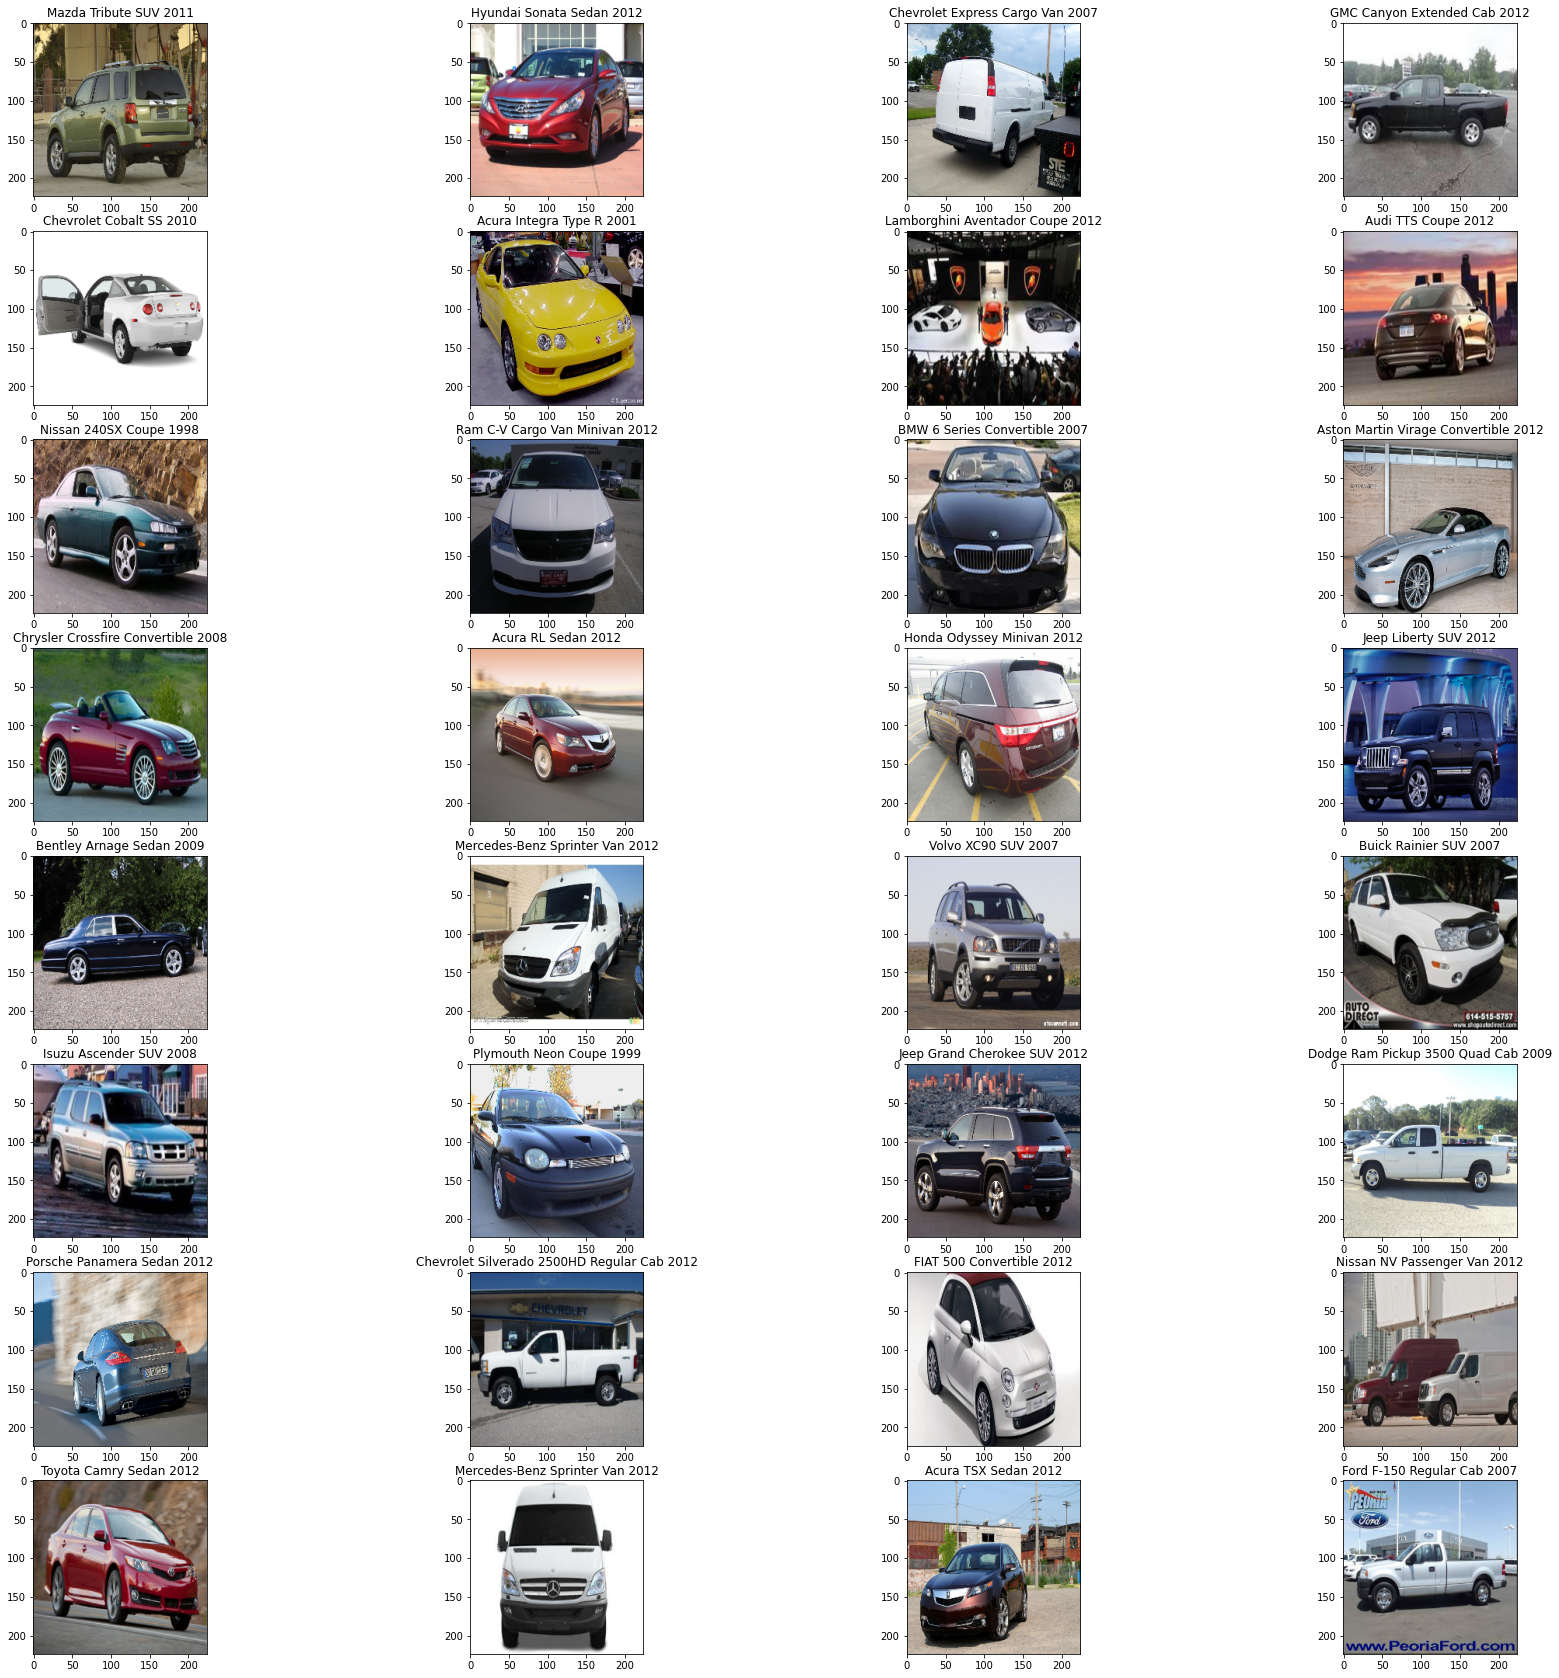

In [7]:
import numpy as np

classes = list(train_data.class_to_idx)


test_loader=iter(test_data_loader)
image, labels = test_loader.next()
image=np.array(image)
nrows=8
ncols=4
plt.figure (figsize = (30, 30))
image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 1, 2))
for i in range(image.shape[0]):
    sp = plt.subplot(nrows, ncols, i+1)
    plt.imshow(image[i])
    plt.title(classes[int(labels[i])])
plt.show()
# print(image.shape, np.mean(image), np.max(image), np.min(image))

In [16]:
dataloaders={
    'train':train_data_loader,
    'val': test_data_loader
}
dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'val']}

def save_checkpoint (state, filename):
    """ saving model's weights """
    print ('=> saving checkpoint')
    torch.save (state, filename)


def load_checkpoint (checkpoint, model):
    """ loading model's weights """
    print ('=> loading checkpoint')
    model.load_state_dict (checkpoint ['state_dict'])


def get_features_labels_train(model):
    features = []
    final_labels = []
    for inputs, labels in train_data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        # print(outputs.shape)
        for i in range(outputs.cpu().shape[0]):
            features.append(np.array(outputs[i].cpu()))
            final_labels.append(np.array(labels[i].cpu()))
        # print(outputs)

    return (features, final_labels)

def get_features_labels_test(model):
    features = []
    final_labels = []
    for inputs, labels in test_data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        # print(outputs.shape)
        for i in range(outputs.cpu().shape[0]):
            features.append(np.array(outputs[i].cpu()))
            final_labels.append(np.array(labels[i].cpu()))
        # print(outputs)

    return (features, final_labels)

dataset_sizes

{'train': 255, 'val': 252}

In [11]:
class ResnetModel(nn.Module):
    def __init__(self, original_model, num_classes):
        super(ResnetModel, self).__init__()

        # Everything except the last linear layer
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        f = self.features(x)
        f = f.view(f.size(0), -1)
        # y = self.classifier(f)
        return f

res_mod = models.resnet50(pretrained=True)
model = ResnetModel(res_mod, num_classes=len(classes))
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('pytorch_total_params= ', pytorch_total_params )
print('pytorch_total_trainable_params= ', pytorch_total_trainable_params)

pytorch_total_params=  23508032
pytorch_total_trainable_params=  0


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
features, labels = get_features_labels_train(model)
features = np.array(features)
labels = np.array(labels)

In [18]:
print(features.shape)
print(labels.shape)

(8144, 2048)
(8144,)


In [19]:
test_features, test_labels = get_features_labels_test(model)
test_features = np.array(test_features)
test_labels = np.array(test_labels)

In [20]:
print(test_features.shape)
print(test_labels.shape)

(8041, 2048)
(8041,)


In [23]:
clf = svm.SVC(kernel='linear') 
clf.fit(features, labels)

SVC(kernel='linear')

In [24]:
pred_train = clf.predict(features)
print("Train Accuracy:",metrics.accuracy_score(labels, pred_train))


Train Accuracy: 1.0


In [25]:
pred_test = clf.predict(test_features)
print("Test Accuracy:",metrics.accuracy_score(test_labels, pred_test))


Test Accuracy: 0.3513244621315757
